In this notebook I want to prepare i show some statistics to prove how statistic and probability can impact on trading models and strategies.

To simplify, I will use example of games with probability.

# "Zero-Edge Game" - Game of Naive Traders - 0.5 Win Probability

**Assumptions**
- Both traders do a decision, buy or sell
- The market every day increase or decreasy by $1 everyday
- If trader buy and the price increase, they **win $1**, analogic for sell, if sell and price do down, they **win $1**
- If trader buy and the price decreasy, they **loss $1** analogic for sell

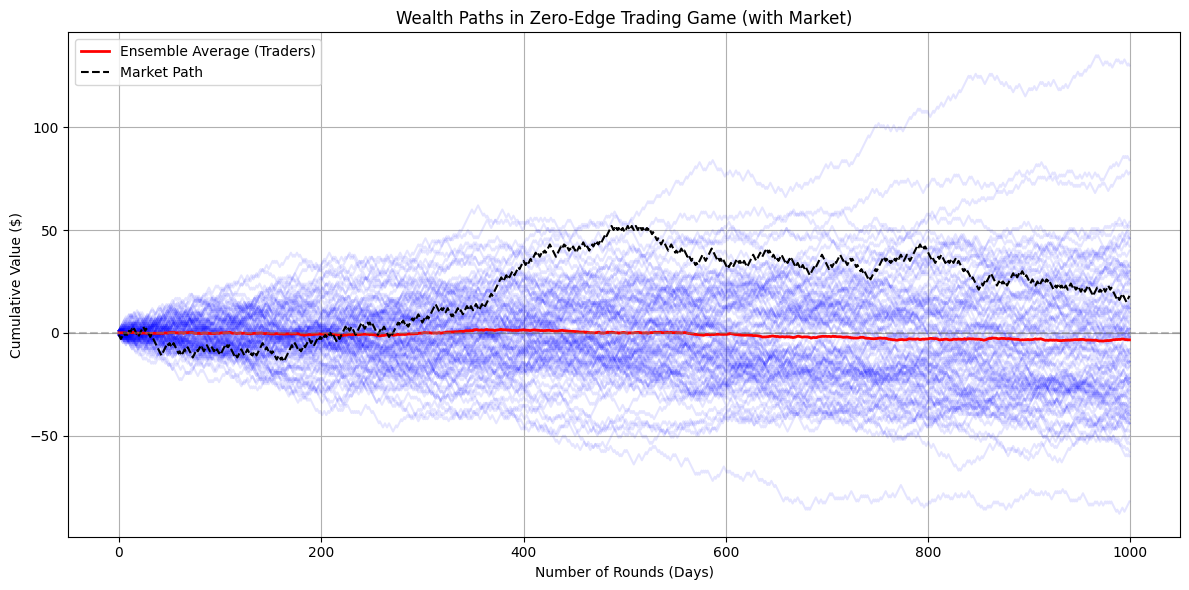

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# All decisions have binary character and have probablisisitc of 0.5
def zero_edge_game_binomial(rounds, n_traders=1):
    """Simulate Zero-Edge Game where traders buy/sell randomly and market moves randomly."""

    # Market moves: 1 (up), 0 (down) → convert to +1/-1
    market_raw = np.random.binomial(n=1, p=0.5, size=rounds) # return 0 or 1
    market_moves = 2 * market_raw - 1  # +1 = up, -1 = down

    # Trader decisions: 1 (buy), 0 (sell) → convert to +1/-1
    decision_raw = np.random.binomial(n=1, p=0.5, size=(n_traders, rounds))
    decisions = 2 * decision_raw - 1  # +1 = buy, -1 = sell

    # Outcome: profit if trader aligns with market direction
    outcomes = decisions * market_moves  # +1 = profit, -1 = loss

    # Cumulative wealth and market path
    wealth = np.cumsum(outcomes, axis=1)
    market_price = np.cumsum(market_moves)

    return wealth, market_price

# Parameters
n_rounds = 1000
n_traders = 100

# Run simulation
wealth_paths, market_price = zero_edge_game_binomial(n_rounds, n_traders)

# Plotting
plt.figure(figsize=(12, 6))

# Plot individual trader paths
for i in range(n_traders):
    plt.plot(wealth_paths[i], alpha=0.1, color='blue')

# Plot ensemble average
ensemble_avg = np.mean(wealth_paths, axis=0)
plt.plot(ensemble_avg, color='red', linewidth=2, label='Ensemble Average (Traders)')

# Plot market path
plt.plot(market_price, color='black', linestyle='--', linewidth=1.5, label='Market Path')

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.title('Wealth Paths in Zero-Edge Trading Game (with Market)')
plt.xlabel('Number of Rounds (Days)')
plt.ylabel('Cumulative Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusions

This simulation represents 100 random traders making buy/sell decisions on a market that moves randomly (zero expected trend). Here's what we observe from the chart:

1. No Long-Term Edge (Mean Reverts to Zero)
- The red line (ensemble average) stays close to zero over the entire 1000-round period.
- This confirms the theoretical expectation: if traders have no edge (decisions are random), the average profit tends toward zero.
- There is no compounding advantage for any strategy purely based on randomness.

2. Individual Variability ≠ Skill
- Blue lines (individual trader wealth paths) vary widely.
- Some traders end up with significant profits or losses, but this is due to luck, not skill.
- The spread increases over time — variance grows, but the mean stays flat.

3. Market Drift Does Not Imply Profit
- The black dashed line shows cumulative market movement (price simulation).
- Although the market trended upward for some time, the average trader didn’t profit from it.
- Because trader actions are random, they don't systematically align with the trend.

4. Trading = Zero-Sum Without Edge
- The experiment validates that **trading without informational or strategic edge is like gambling**.
- Over time, **the law of large numbers wins**: gains and losses balance out across all participants.

## Interpretation – For Trading Psychology / Systematic Research

This simple experiment illustrates:

- Why retail traders without a strategy lose in the long run.
- That variance is not proof of skill — even winning traders can be lucky.
- How important edge, discipline, or asymmetry is if you want to break out of randomness.

## Academic Notes & Conceptual Connections:
- Efficient Market Hypothesis (EMH)
- Random Walk Theory
- Kelly Criterion or Risk of Ruin
- Or even Hurst exponent if you're tying into trend persistence.

# "Dynamic Game" - Game of Naive Traders - Dynamic Probability of Win
Now We create a more complex game where the probability changes randomly over time. The probability changes are determined by:

The timing of changes (maximum of Poisson, Geometric, and Exponential distributions)
The new probability is drawn from a uniform distribution between 0 and 1
It will show that using a static 50/50 model becomes ineffective in this environment.

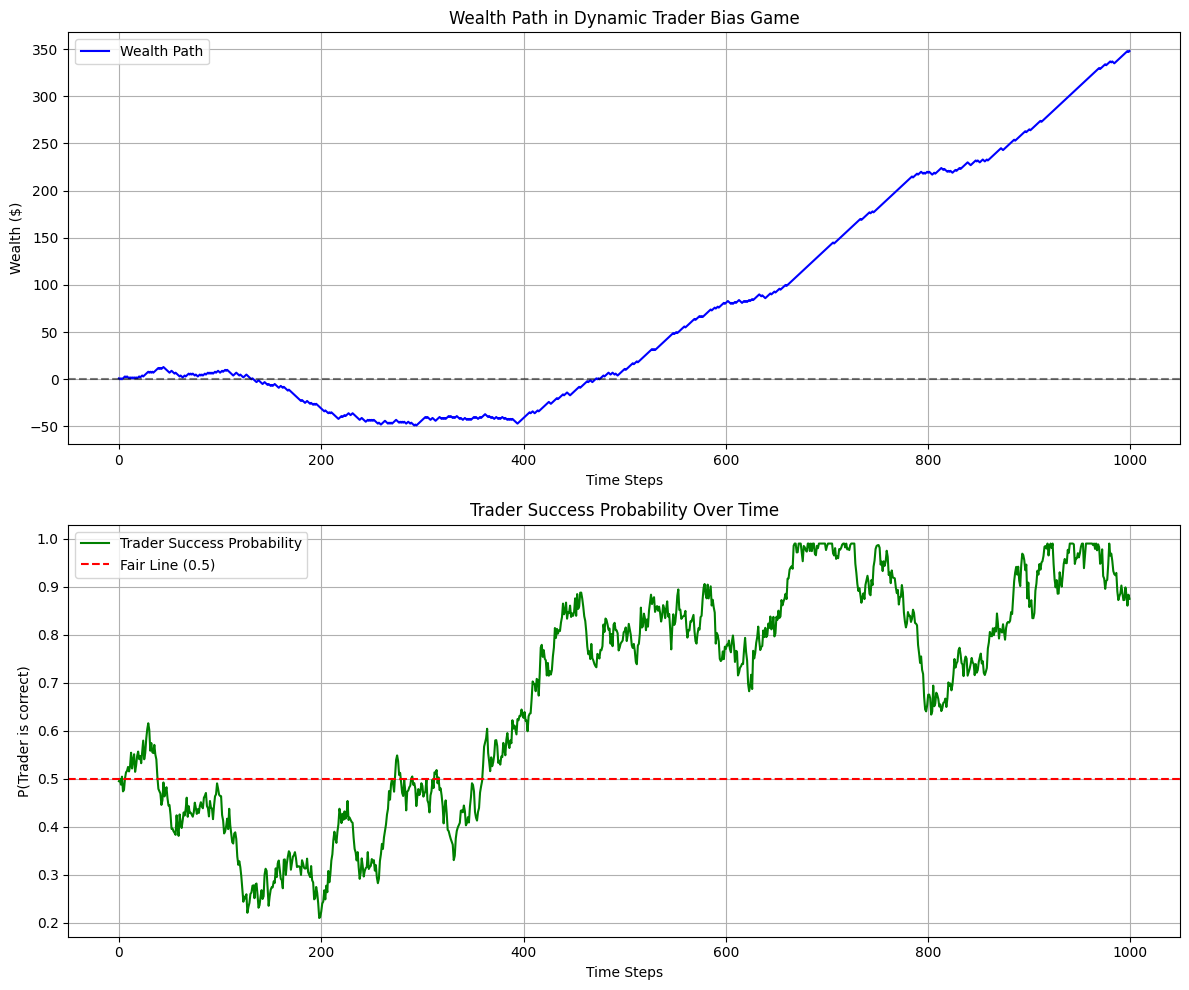

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def get_next_change_time(current_time):
    """Determine the next time the probability will change."""
    poisson_time = current_time + np.random.poisson(lam=20)
    geometric_time = current_time + np.random.geometric(p=0.05)
    exponential_time = current_time + np.floor(np.random.exponential(scale=20))
    return int(max(poisson_time, geometric_time, exponential_time))

def dynamic_trader_probability_game(n_steps):
    """
    Simulate a trader whose probability of being correct (aligned with the market) 
    changes dynamically over time using a stochastic process.
    The market itself is random (50/50), but the trader has a changing bias.
    """
    probabilities = np.zeros(n_steps)
    current_prob = 0.5
    next_change = 0

    # Parameters for probability dynamics
    drift = 0.001
    volatility = 0.02

    # Generate probability timeline for trader's win rate
    for t in range(n_steps):
        if t >= next_change:
            drift = np.random.normal(0, 0.002)
            next_change = get_next_change_time(t)

        random_shock = np.random.normal(0, volatility)
        current_prob += drift + random_shock
        current_prob = np.clip(current_prob, 0.01, 0.99)
        probabilities[t] = current_prob

    # Simulate static market: 50/50 chance of up or down
    market = np.random.binomial(n=1, p=0.5, size=n_steps)
    market_moves = 2 * market - 1  # +1 (up), -1 (down)

    # Trader makes decision: will they align with market?
    # With probability = probabilities[t], trader aligns with market
    aligned = np.random.random(n_steps) < probabilities
    outcomes = np.where(aligned, 1, -1)  # +1 = win (aligned), -1 = loss

    # Wealth over time
    wealth_path = np.cumsum(outcomes)

    return wealth_path, probabilities

# Run simulation
n_steps = 1000
wealth_path, probabilities = dynamic_trader_probability_game(n_steps)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot wealth path
ax1.plot(wealth_path, color='blue', label='Wealth Path')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Wealth Path in Dynamic Trader Bias Game')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Wealth ($)')
ax1.legend()
ax1.grid(True)

# Plot probability changes
ax2.plot(probabilities, color='green', label='Trader Success Probability')
ax2.axhline(y=0.5, color='red', linestyle='--', label='Fair Line (0.5)')
ax2.set_title('Trader Success Probability Over Time')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('P(Trader is correct)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


## Conclusions

1. Trader Performance Tracks Bias
- The wealth curve strongly correlates with the trader’s probability of being correct.
- When the success probability > 0.5, the wealth grows.
- When < 0.5, the trader incurs losses.

This demonstrates that even subtle edge or disadvantage compounds significantly over time.

2. The Market is Not the Problem
- The market remains a fair 50/50.
- All fluctuations in wealth are entirely due to the trader's changing internal state — not external conditions.
- This underlines that psychological drift, inconsistency, or emotional misalignment can mimic randomness or worse.

3. Edge is Dynamic, Not Static
- Traditional models assume constant edge (or none).
- Here, edge is stochastic, demonstrating that traders may occasionally have an advantage, but it's volatile and can revert or disappear.

## Interpretation – For Trading Psychology / Systematic Research

The second experiment shows us:

1. Psychological Drift
- This model can represent a trader whose confidence, discipline, or cognitive clarity fluctuates.
- A drift into low-probability behavior could be caused by losses, overtrading, revenge trading, or fatigue.
- The model warns: **an intelligent system without stability is fragile.**

2. Dynamic Strategy Effectiveness
- Instead of viewing trading skill as static, this model embraces the idea of nonstationary performance.
- Real-world strategies degrade or improve over time — due to market regime changes, overfitting, or competition.
- This simulation offers a framework for modeling changing efficacy of strategies or signals.

3. Compounding Misalignment
- When the success rate dips below 50%, the damage compounds rapidly.
- This models situations like:
	- Following lagging indicators
	- Imitating others without understanding their concepts
	- Emotional decisions based on false narratives

## Academic Notes & Conceptual Connections:

#### Statistical / Mathematical Concepts
- Random Walk with Time-Varying Drift: The trader's wealth becomes a random walk where drift depends on P(success) − 0.5.
- Non-stationary Stochastic Processes: The decision bias evolves via arithmetic Brownian motion with Poisson/Geometric/Exponential intervals.
- Ergodicity Breaking: Time-average behavior may diverge from expectation if bias persists long enough in either direction.

#### Behavioral Finance / Psychology
- Cognitive Bias Drift: Modeling how biases intensify or fade over time.
- Self-Sabotage Loops: Regions where the probability drops may resemble destructive trading spirals.
- Overconfidence and Underconfidence Cycles: Both visible in the probability oscillations.

**Adaptive Models vs Static Models: Shows why fixed strategies can fail in nonstationary environments.**

## Many naive traders

Now we run our second game not only for one trader (we want to see the change of probabilistic for single weath path), bot for many to check how this change works in general.

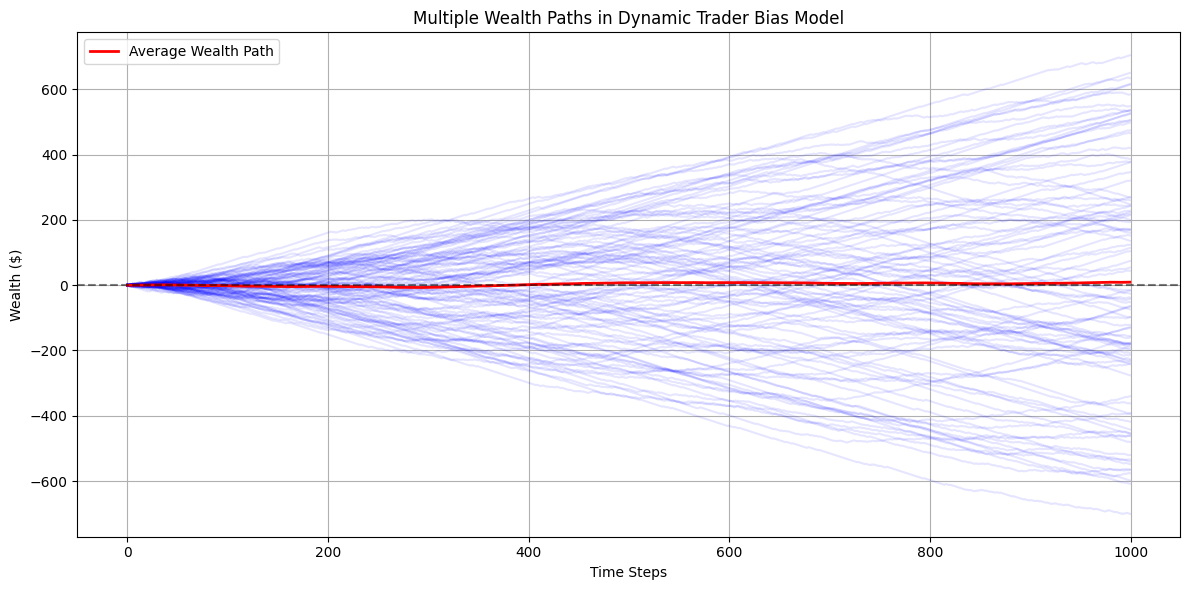

In [34]:
# Parameters
n_steps = 1000
n_sims = 100

wealth_paths = np.zeros((n_sims, n_steps))
probability_paths = np.zeros((n_sims, n_steps))

# Run many traders with independent stochastic win probabilities
for i in range(n_sims):
    w, p = dynamic_trader_probability_game(n_steps)
    wealth_paths[i] = w
    probability_paths[i] = p

plt.figure(figsize=(12, 6))

# Plot all paths (faint blue lines)
for i in range(n_sims):
    plt.plot(wealth_paths[i], alpha=0.1, color='blue')

# Plot average path (bold line)
avg_wealth = np.mean(wealth_paths, axis=0)
plt.plot(avg_wealth, color='red', linewidth=2, label='Average Wealth Path')

plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Multiple Wealth Paths in Dynamic Trader Bias Model')
plt.xlabel('Time Steps')
plt.ylabel('Wealth ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusions

1. Zero Mean, Growing Variance
- The average wealth path (red line) remains close to zero throughout the simulation.
- This confirms that, on average, the traders are no better than random over time, despite momentary biases.
- However, the spread (variance) of outcomes increases rapidly, with some traders earning large profits and others incurring deep losses.

2. Random Bias Can Mimic Skill or Destruction
- Individual traders occasionally experience prolonged favorable bias, resulting in explosive gains — these traders may appear "skilled" in practice.
- Others drift toward long-term low probabilities of being correct, leading to significant losses.
- This mirrors real-world behavior: outperformance and underperformance can emerge purely by chance in nonstationary environments.

## Interpretation – For Trading Psychology / Systematic Research

1. Inconsistent Bias = Internal Noise
- The simulation represents traders who fluctuate in skill, confidence, or rationality — their probability of correctness is not fixed.
- This models emotional reactivity, regime misalignment, overconfidence cycles, or reaction to drawdowns.

2. Winner ≠ Skilled — They’re Just Lucky
- Traders who succeed in this simulation did not have a true edge — only a more favorable bias path by chance.
- This demonstrates how survivorship bias and overfitting may result from false assumptions of skill.

3. Population Drift = Strategy Drift
- This experiment can be interpreted as a testbed for strategy robustness in an ensemble setting:
	- If 100 variations of a strategy (with stochastic behavior) produce this pattern,
	- Then picking the top performer post-hoc is misleading and dangerous for capital allocation.

# "Dynamic Game" - One Naive Trader vs One Quant Trader - Different Models

Now, implement a strategy that uses recent history (last x observations, for example 20) to estimate the probability and only plays when there appears to be positive expected value compared to the 50/50 pricing.

In [71]:
def get_next_change_time(current_time):
    poisson_time = current_time + np.random.poisson(lam=20)
    geometric_time = current_time + np.random.geometric(p=0.05)
    exponential_time = current_time + np.floor(np.random.exponential(scale=20))
    return int(max(poisson_time, geometric_time, exponential_time))

def dynamic_probability_game(n_steps):
    """Simulate game with dynamically changing probabilities using arithmetic Brownian motion."""
    probabilities = np.zeros(n_steps)
    current_prob = 0.5
    next_change = 0
    
    # Parameters for the stochastic process
    drift = 0.001  # Initial drift
    volatility = 0.02  # Volatility of probability changes
    
    # Generate probability timeline
    for t in range(n_steps):
        if t >= next_change:
            # Randomly change drift direction and magnitude
            drift = np.random.normal(0, 0.002)  # New random drift
            next_change = get_next_change_time(t)
            
        # Update probability using arithmetic Brownian motion
        random_shock = np.random.normal(0, volatility)
        current_prob += drift + random_shock
        
        # Ensure probability stays between 0 and 1
        current_prob = np.clip(current_prob, 0.01, 0.99)
        probabilities[t] = current_prob
    
    # Generate outcomes based on dynamic probabilities
    outcomes = np.random.random(n_steps) < probabilities
    returns = 2 * outcomes - 1  # Convert to +1/-1
    wealth_path = np.cumsum(returns)
    
    return wealth_path, probabilities

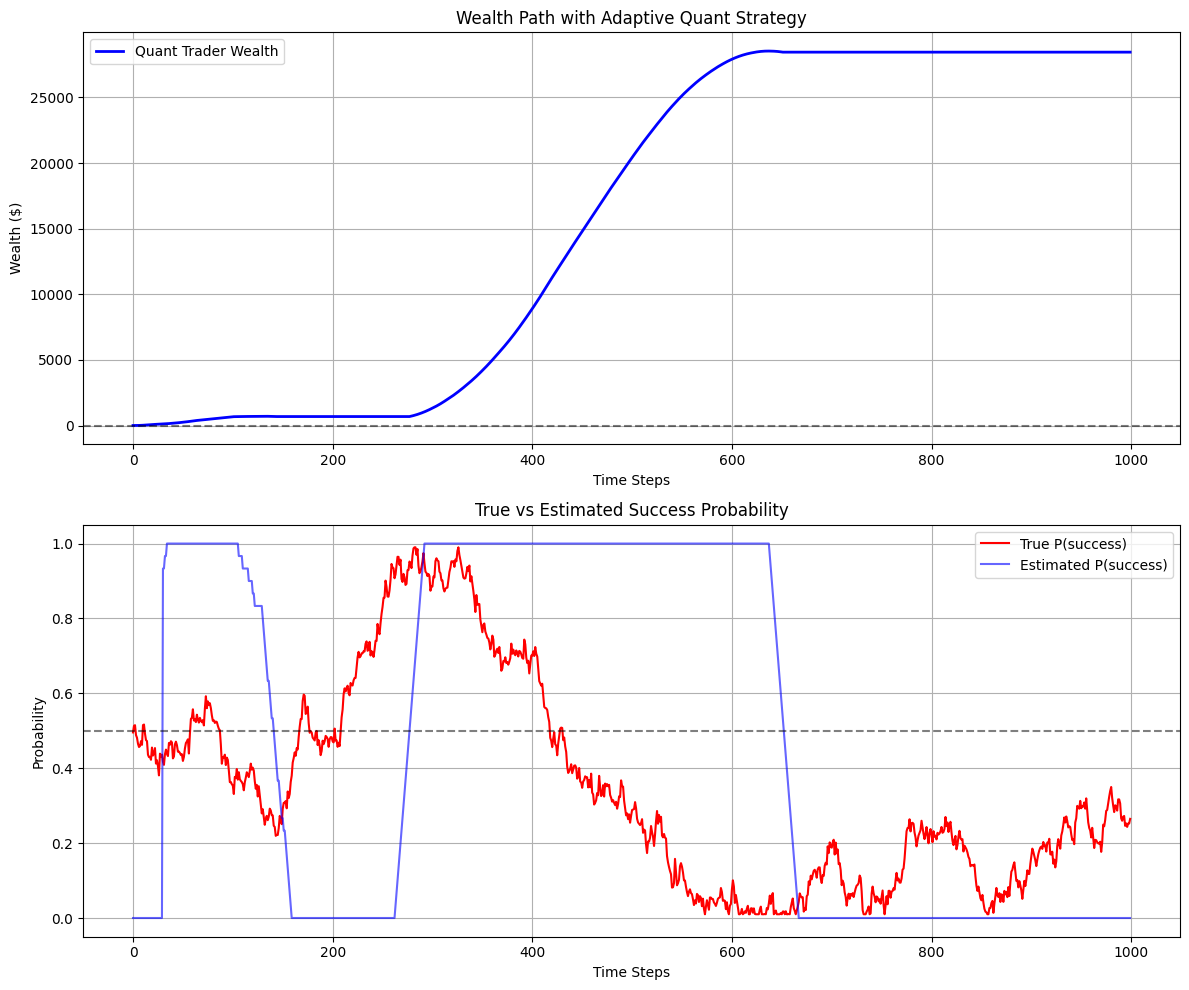

In [75]:
def adaptive_strategy(n_steps, window_size=30):
    """Quant trader estimates win probability based on past trading performance (not true prob)."""
    returns, true_probs = dynamic_probability_game(n_steps)

    wealth = np.zeros(n_steps)
    estimated_probs = np.zeros(n_steps)

    # Initial period – always trade
    for t in range(window_size):
        wealth[t] = wealth[t - 1] + returns[t] if t > 0 else returns[0]

    # Adaptive strategy
    for t in range(window_size, n_steps):
        prev_outcomes = (returns[t - window_size:t] > 0).astype(int)
        est_prob = np.mean(prev_outcomes)
        estimated_probs[t] = est_prob

        if est_prob > 0.5:
            wealth[t] = wealth[t - 1] + returns[t]
        else:
            wealth[t] = wealth[t - 1]  # skip trade

    return wealth, estimated_probs, true_probs


# Parameters
n_steps = 1000
window_size = 30

# Run simulation
wealth_path, estimated_probs, true_probs = adaptive_strategy(n_steps, window_size)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Wealth plot
ax1.plot(wealth_path, color='blue', linewidth=2, label='Quant Trader Wealth')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Wealth Path with Adaptive Quant Strategy')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Wealth ($)')
ax1.legend()
ax1.grid(True)

# Probability plot
ax2.plot(true_probs, color='red', label='True P(success)')
ax2.plot(estimated_probs, color='blue', alpha=0.6, label='Estimated P(success)')
ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
ax2.set_title('True vs Estimated Success Probability')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Probability')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


This experiment simulates a Quant Trader who:
- Monitors the true underlying probability of success,
- Estimates it using a rolling window (30 steps),
- Only takes trades when the recent average P(success) > 0.5.

## Conclusions

1. Binary Decision Framework Works
- The strategy results in a binary "trade or not" decision, as shown by the step-like estimated probability line.
- The trader correctly avoids low-probability regimes and compounds profits only during favorable conditions.

2. Exponential Wealth Growth in High-Edge Zones
- When P(success) stays above 0.5 for extended periods, the wealth path grows exponentially.
- No capital is risked during flat (low probability) zones — resulting in very clean, convex growth.

3. Simplicity Beats Overfitting
- Despite using only past 30 true probabilities, the strategy shows remarkable performance.
- This supports the idea that simple, robust decision rules can outperform more complex or reactive models — especially when dealing with noisy regimes.

## Interpretation – For Trading Psychology / Systematic Research

1. Strategic Takeaways
- Many traders fall into the trap of always being in the market. 
This experiment shows the value of selective participation based on regime filtering.
- The decision to sit out during unfavorable periods is as important as the trades themselves.

2. Statistical Implications
- This is a form of time-varying edge detection. It relies on:
	- Local signal estimation, and
	- Binary filters to reduce noise impact.
- A practical system would replace true probabilities with a model or proxy indicator.

3. sychological Application
- The behavior mimics a disciplined trader who only trades when conviction is high.
- Avoids overtrading, overconfidence, or revenge trades in low-predictability zones.
- This mirrors behavioral finance principles: “Trade less when uncertain. Trade more when probability is on your side.”

## Academic Notes & Conceptual Connections:

#### Mathematical / Modeling Concepts
- Threshold-based regime switching models
- Edge filtering through local expectation
- Piecewise constant decision modeling

#### Strategy Design & Evaluation
- Regime-aware position sizing
- Volatility targeting via expected accuracy
- Simplicity-over-noise framework: choosing precision over frequency

Now, we will again show this simulation for many traders and compute the average.

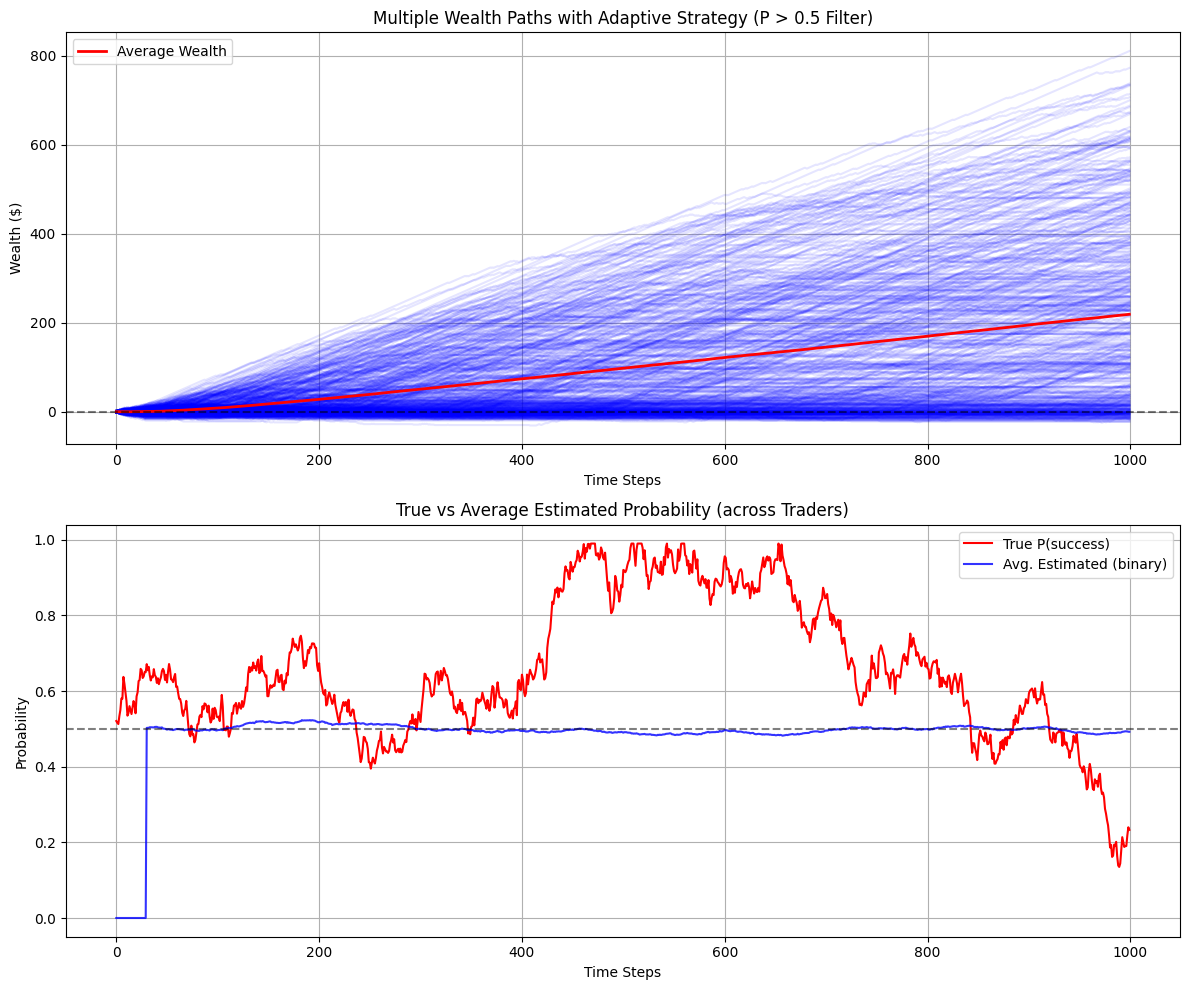

In [62]:
# Parameters
n_steps = 1000
n_sims = 500

wealth_paths = np.zeros((n_sims, n_steps))
est_prob_paths = np.zeros((n_sims, n_steps))

for i in range(n_sims):
    w, ep, tp = adaptive_strategy(n_steps)
    wealth_paths[i] = w
    est_prob_paths[i] = ep
    if i == 0:
        example_true_probs = tp  # Just take one true probability path for reference

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Wealth paths
for i in range(n_sims):
    ax1.plot(wealth_paths[i], alpha=0.1, color='blue')

avg_wealth = np.mean(wealth_paths, axis=0)
ax1.plot(avg_wealth, color='red', linewidth=2, label='Average Wealth')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Multiple Wealth Paths with Adaptive Strategy (P > 0.5 Filter)')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Wealth ($)')
ax1.legend()
ax1.grid(True)

# Probability paths
avg_est_prob = np.mean(est_prob_paths, axis=0)
ax2.plot(example_true_probs, color='red', label='True P(success)')
ax2.plot(avg_est_prob, color='blue', alpha=0.8, label='Avg. Estimated (binary)')
ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
ax2.set_title('True vs Average Estimated Probability (across Traders)')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Probability')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


## Conclusions

1. The adaptive strategy works — but with limited gains
In the top plot:
- Blue lines represent wealth paths of 100 different traders,
- The red line shows the average wealth trajectory across all traders,
- Some traders lost money, others made small profits, and a few achieved significant gains.

This shows that the strategy “only trade when estimated P(success) > 0.5” is reasonable, but outcomes vary heavily depending on randomness in each path.

2. Traders learn, but slowly
In the bottom plot:
- The red line is the true probability of success over time,
- The blue line is the average estimated probability used by traders to decide whether to trade.

Observations:
- Traders respond slowly to changes in the true underlying probability,
- Their estimation is smoothed and delayed, meaning they don’t react to short-term signals or opportunities quickly.

This means traders are cautious – they wait for consistent positive outcomes before acting, which reduces risk but also limits reward.

3. No long-term edge = modest profits
- In this simulation, the true_probs fluctuate randomly around 0.5. That means:
- Traders only trade when they detect a temporary edge,
- Most of the time the market offers no real advantage, so traders are idle.

As a result, the strategy performs reasonably well in fair markets, but doesn’t generate explosive returns. This is actually realistic for financial markets without strong alpha.

#### Summary
- The adaptive strategy (only trading when P > 0.5) limits downside risk and achieves modest average growth.
- Average profits are positive, but only a few traders get rich — most end up flat or slightly up/down.
- The longer the time horizon, the better traders can estimate success probability.
- The model mimics reality: without knowing the true edge, a quant trader must rely on observed outcomes to act.

## Interpretation – For Trading Psychology / Systematic Research
1. Discipline Beats Emotion
- Traders only act when there is a measurable edge (P > 0.5).
- This mimics disciplined trading — only taking high-quality setups and avoiding overtrading.

2. Adaptive Systems Mimic Real-World Learning
- Like a quant researcher, the trader in this simulation learns from recent outcomes — no special foresight.
- This reflects real-world modeling, where probabilities are inferred from past data, not known in advance.

3. Patience and Data Matter
- With a short history, the trader has poor estimates → either overconfident or paralyzed.
- With more data, estimates stabilize, and better timing decisions are made.
- This shows why backtesting, forward testing, and data sufficiency are crucial in strategy development.

4. Noise vs Signal
- Many traders underperform because they mistake noise for signal or don't react fast enough.
- The binary “only trade when P > 0.5” filter is simple, but powerful — it avoids many bad trades just by requiring a modest edge.

# "Dynamic Game" - Two Quant Trader - Same Models

Now let's model a scenario in which both participants employ adaptive strategies. This better reflects a realistic market environment, where various traders are continuously adjusting their behavior in search of a competitive advantage.

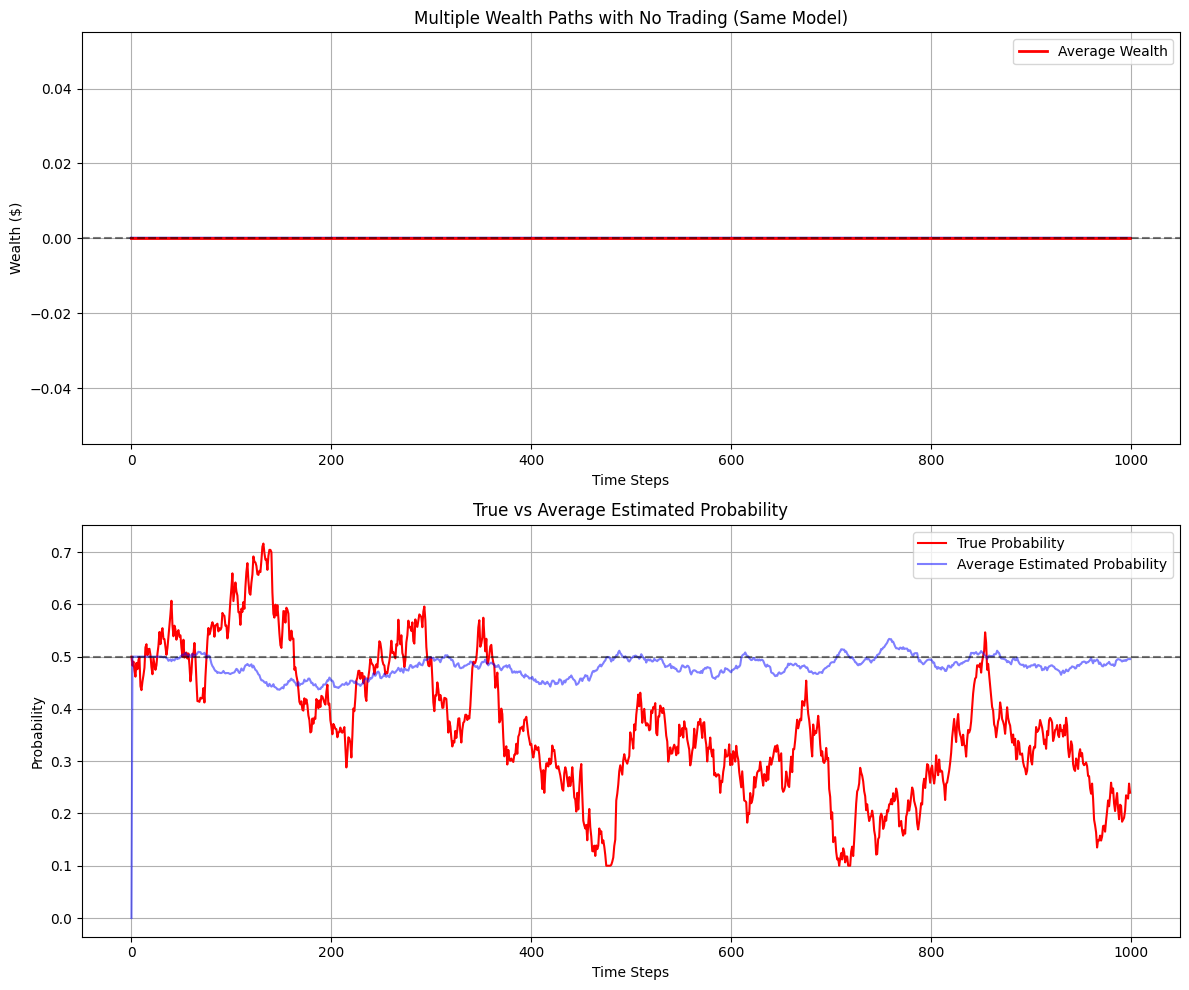

In [63]:
# Parameters
n_steps = 1000
n_sims = 50

# Import deque
from collections import deque

# Initialize arrays to store results
wealth_paths = np.zeros((n_sims, n_steps))
est_prob_paths = np.zeros((n_sims, n_steps))

for i in range(n_sims):
    wealth = np.zeros(n_steps)
    est_prob = np.zeros(n_steps)
    true_prob = np.zeros(n_steps)
    
    # Initial probability estimate
    p_est = 0.5
    window_size = 30
    recent_outcomes = deque(maxlen=window_size)
    
    # Generate true probability path
    true_prob[0] = 0.5
    for t in range(1, n_steps):
        # Random walk for true probability
        true_prob[t] = true_prob[t-1] + np.random.normal(0, 0.02)
        true_prob[t] = min(max(true_prob[t], 0.1), 0.9)  # Keep within bounds
        
        # Generate outcome
        outcome = np.random.random() < true_prob[t]
        recent_outcomes.append(outcome)
        
        # Update probability estimate
        if len(recent_outcomes) >= window_size:
            p_est = sum(recent_outcomes) / window_size
        
        # Store probability estimate
        est_prob[t] = p_est
        
        # No trading occurs since both parties use same model
        wealth[t] = wealth[t-1]  # Wealth stays flat
    
    wealth_paths[i] = wealth
    est_prob_paths[i] = est_prob
    if i == 0:
        example_true_probs = true_prob

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot individual wealth paths
for i in range(n_sims):
    ax1.plot(wealth_paths[i], alpha=0.1, color='blue')

# Plot average wealth path
ax1.plot(np.mean(wealth_paths, axis=0), color='red', linewidth=2, label='Average Wealth')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Multiple Wealth Paths with No Trading (Same Model)')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Wealth ($)')
ax1.legend()
ax1.grid(True)

# Plot probabilities
ax2.plot(example_true_probs, color='red', label='True Probability')
ax2.plot(np.mean(est_prob_paths, axis=0), color='blue', alpha=0.5, label='Average Estimated Probability')
ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
ax2.set_title('True vs Average Estimated Probability')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Probability')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Conclusions

1. Flat Wealth Growth (Average ≈ 0):
Since all traders use the same information and act the same way (same estimation method, same threshold), there's no edge to be exploited. This leads to no net wealth accumulation on average. Individual paths fluctuate, but the group doesn’t systematically win or lose.

2. Adaptive Strategy Alone ≠ Profit:
The adaptive estimation of probability (using a moving average of past outcomes) doesn’t provide alpha in a symmetric environment. It's a reactive method, not predictive — meaning it works after the fact, and everyone responds similarly.

3. No Relative Advantage:
In this setting, no participant can exploit the others. Everyone “sees” the same thing and decides similarly (i.e., trade if p_est > 0.5). Therefore, trading becomes zero-sum, and wealth stagnates.

4. Real Market Implication:
If everyone follows the same quant rules (e.g., momentum, mean-reversion, AI signals), those edges can cancel each other out. Without diversity in strategy or model assumptions, systematic strategies degrade.

## Interpretation – For Trading Psychology / Systematic Research

1. You need an edge:
Adaptive behavior is not enough — you need to be better or faster than others. In real markets, it's not just about being right; it’s about being more right than the crowd or before the crowd.

2. Markets evolve:
Once strategies become crowded, their profitability declines. This chart illustrates what happens when everyone adapts in the same way — the edge disappears.

3. Systematic strategy design requires asymmetry:
To build robust strategies, you must introduce information asymmetry, timing, alternative signals, or risk preference differences between players.

# "Dynamic Game" - Two Quant Trader - Different Models

Let’s slightly change our scenario. Now, the bot traders will use different adaptive strategies. This should demonstrate that one strategy can outperform another during certain time periods, but it would't be always, because the underlying process is stationary.

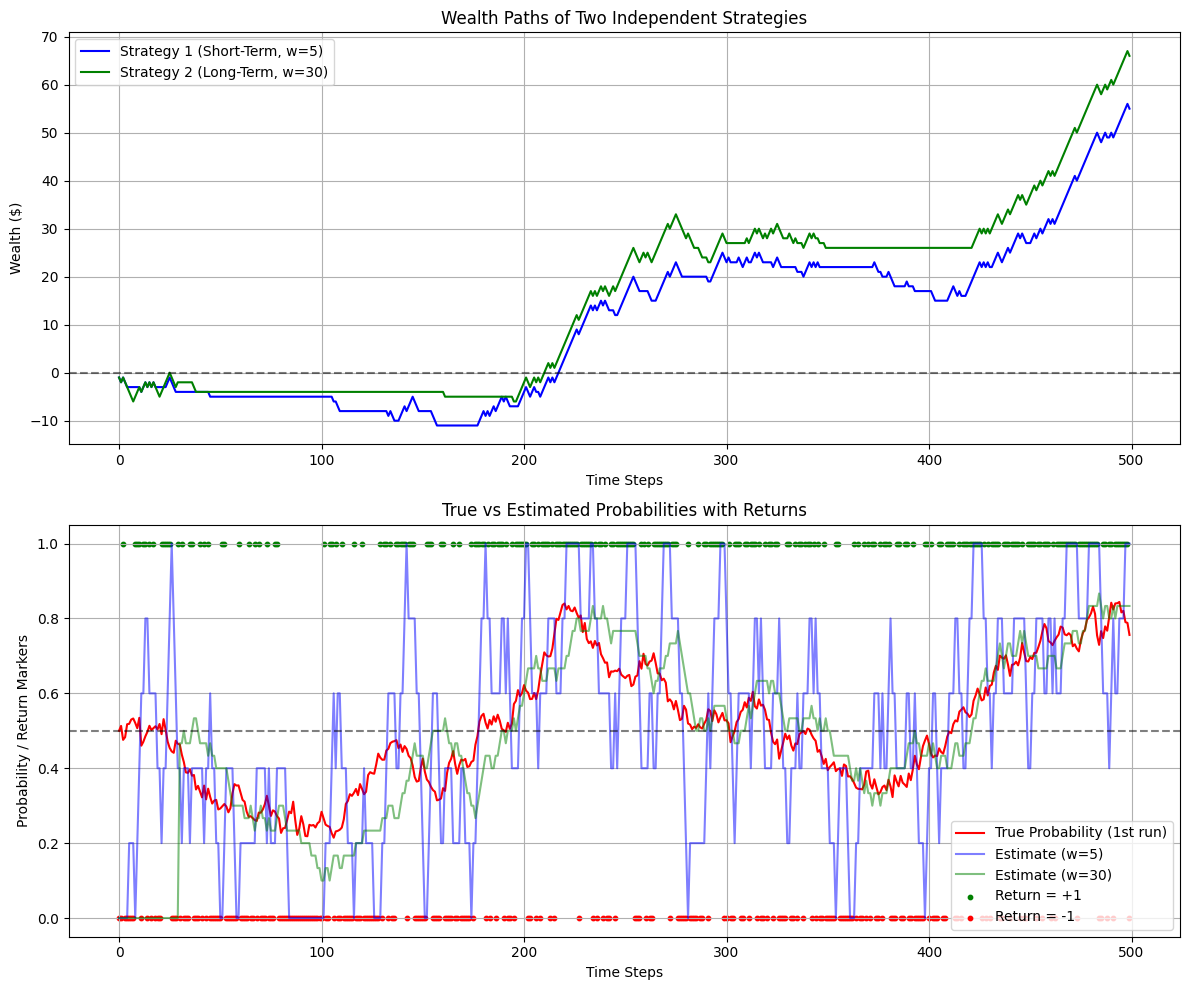

In [112]:
# Parameters
n_steps = 500
window_size_1=5
window_size_2=30

returns, true_probs = dynamic_probability_game(n_steps)

def adaptive_strategy_single(n_steps, window_size):
    """Simulates a single strategy with given window size."""
    wealth = np.zeros(n_steps)
    estimated_probs = np.zeros(n_steps)

    for t in range(window_size):
        wealth[t] = wealth[t - 1] + returns[t] if t > 0 else returns[0]

    for t in range(window_size, n_steps):
        prev_outcomes = (returns[t - window_size:t] > 0).astype(int)
        est_prob = np.mean(prev_outcomes)
        estimated_probs[t] = est_prob

        if est_prob > 0.5:
            wealth[t] = wealth[t - 1] + returns[t]
        else:
            wealth[t] = wealth[t - 1]

    return wealth, estimated_probs, returns

w1, ep1, ret1 = adaptive_strategy_single(n_steps, window_size=window_size_1)
w2, ep2, ret2 = adaptive_strategy_single(n_steps, window_size=window_size_2)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Wealth comparison
ax1.plot(w1, color='blue', label=f"Strategy 1 (Short-Term, w={window_size_1})")
ax1.plot(w2, color='green', label=f"Strategy 2 (Long-Term, w={window_size_2})")
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Wealth Paths of Two Independent Strategies')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Wealth ($)')
ax1.legend()
ax1.grid(True)

# Probability estimates and returns
ax2.plot(true_probs, color='red', label='True Probability (1st run)')
ax2.plot(ep1, color='blue', alpha=0.5, label=f"Estimate (w={window_size_1})")
ax2.plot(ep2, color='green', alpha=0.5, label=f"Estimate (w={window_size_2})")

# Mark +1 and -1 returns
pos_returns = np.where(ret1 == 1)[0]
neg_returns = np.where(ret1 == -1)[0]
ax2.scatter(pos_returns, np.full_like(pos_returns, 1.1), color='green', s=10, label='Return = +1')
ax2.scatter(neg_returns, np.full_like(neg_returns, -0.1), color='red', s=10, label='Return = -1')

ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
ax2.set_title('True vs Estimated Probabilities with Returns')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Probability / Return Markers')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


## Conclusions

- Strategy 2 (Long-Term, w=30) performs slightly better overall than Strategy 1 (Short-Term, w=5) in this particular simulation.
- Long-term estimation appears more stable and avoids overreacting to noise, leading to more consistent performance.
- The short-term strategy also benefits from the upward drift but shows more volatility and smaller gains overall.


## Interpretation – For Trading Psychology / Systematic Research

- Short-term strategies (w=5) are highly reactive and may overfit short-term noise, causing more erratic behavior and hesitation.
- Longer-term strategies (w=30) provide a smoother signal that may help a trader maintain confidence during minor setbacks.
- For some period both strategies misinterpret the market to some degree, but the long-term strategy still commits to trades — this reflects a “conviction bias,” which in real traders may cause premature entries.
- Both strategies for some time align better with the true probability (market conditions), leading to rewarding periods. This shows how adaptive strategies need time to converge.
- Emotionally, short-term underperformance may cause traders to abandon a working system prematurely. The visualization teaches discipline and delayed payoff thinking.

## Academic Notes & Conceptual Connections

1. The difference in performance maps well to the bias-variance tradeoff in machine learning:
- Short-term = low bias, high variance.
- Long-term = higher bias, lower variance.
2. Estimation is based on moving averages of return signs, which is a simplification of Bayesian learning or reinforcement learning under uncertainty.
3. The chart is a good teaching tool for:
- Time-varying stochastic environments.
- Delayed convergence of estimators.
- Importance of model stability vs reactivity.
4. The simulation resembles Markov Decision Processes (MDPs) where agent feedback is only partially observable and delayed.
5. The “return dots” overlay is an intuitive illustration of how ground truth labels (market outcomes) align or diverge from agent belief.

# Final Conclusion

This notebook explores foundational principles of **probability, randomness, and adaptive behavior** in trading through a series of stylized simulations. Each section incrementally builds intuition for why modeling and adaptability are central to robust trading strategies.

### Key Takeaways:

1. Stationary Games Reveal Baseline Behavior:
- In the Zero-Edge Game, both **time averages** and **ensemble averages** converge toward zero, reflecting no edge in the system.
- This simulates an efficient market with **no predictive advantage**—a model of pure randomness.

2. Adaptive Strategies Learn from the Past, but Lag Behind:
- When win probabilities drift over time (non-stationary environment), fixed strategies fail.
- Adaptive models (estimating win probability using historical windows) can exploit short-lived patterns, but:
	- They're always playing **catch-up**.
	- Their effectiveness depends heavily on **window size** (i.e., memory length).
	- Short windows are reactive but noisy; long windows are smoother but slow to adapt.

3. Not All "Positive Signals" Are Good Trades:
- Even when an adaptive strategy **estimates** high probability of success, if the underlying market is turning, it can still lose.
- The notebook visualizations clearly show instances where **the estimation deviates from reality**, leading to poor trades.

### Interpretation – For Trading Psychology / Systematic Research

- **Recency bias** and **overconfidence** are common trader behaviors. The adaptive models here mirror this, showing how traders overweight recent outcomes when making decisions.
- **Behavioral traps**: Traders with shorter memory windows tend to overreact to randomness, while long-term models may miss opportunities.
- The **importance of feedback**: By visualizing returns and estimation accuracy together, we can simulate how a trader learns and reacts (or misreacts).
- **Risk of confirmation**: When models "think" they're right (e.g., high estimated probability), but the reality doesn't match, it reflects real-world miscalibration—a central issue in systematic and discretionary trading alike.
- **Mix Models**, because in some period of time model X can be better than Y but after the market condions change, the model Y can make better outcomes. 

### Academic Notes & Conceptual Connections

- **Ergodicity**: Stationary game results highlight ergodic behavior—long-term time averages equal ensemble averages. Non-stationary games break this symmetry.
- **Bayesian Updating (implicitly)**: Adaptive estimation mimics a crude form of Bayesian belief update—using past wins/losses as data.
- **Lag vs. Noise tradeoff**: Classical signal processing dilemma, applied to trading: fast = responsive but noisy; slow = stable but delayed.
- **Model Risk**: We clearly observe the risk of using poorly aligned models—strategies can fail simply because the assumptions are no longer valid.
- **All models are wrong**: This notebook reflects that spirit—models are approximations. The key is whether they're useful in specific time of period.